# Introductoin
- lightGBM

# Import everythng I need :)

In [1]:
import time
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# lightGBM Regressior(not using test data)

## preparation data

In [2]:
boston = load_boston()
# feature_names = boston.feature_names
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.9,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14


In [6]:
X = df
y = boston.target

## set params

In [4]:
# Configuration
N_ESTIMATORS = 1000          # 最大学習回数
VERBOSE = 50               # 50回ごとに評価する
EARLY_STOPPING_ROUNDS = 100  # 100回の学習でよくならなければ、学習をとめる
RANDOM_STATE = 42
METRIC = mean_squared_error

# lgb_params
lgb_params = {'num_leaves': 31,
          'min_child_samples': 30,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mse',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }

## K-Fold

**5 fold**

In [7]:
n_folds = 5
folds = KFold(n_splits=n_folds, shuffle=True)

scores = []
models = []
feature_importance = pd.DataFrame()
feat = X.columns
for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X)):
    print('------------------')
    print(f'- fold{fold_n + 1}' )
    print(f'Fold {fold_n + 1} started at {time.ctime()}')
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]
    
    # Train the model
    model = lgb.LGBMRegressor(**lgb_params, n_estimators=N_ESTIMATORS, n_jobs=-1)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              verbose=VERBOSE,
              early_stopping_rounds=EARLY_STOPPING_ROUNDS)
    
    
    # predict
    oof = model.predict(X_valid, num_iteration=model.best_iteration_)   # oof: out of folds
    scores.append(round(METRIC(y_valid, oof), 4))
    
    # feature_importance
    fold_importance = pd.DataFrame()
    fold_importance['feature'] = X.columns
    fold_importance['importance'] = model.feature_importances_
    fold_importance['fold'] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
feature_importance["importance"] /= folds.n_splits

print('------------------')
print('====== finish ======')
print('score list:', scores)
print('CV mean score: {0:.4f}, std: {1:.4f}'.format(np.mean(scores), np.std(scores)))

------------------
- fold1
Fold 1 started at Fri Jul 12 09:46:26 2019
Training until validation scores don't improve for 100 rounds.
[50]	training's l2: 4.86981	valid_1's l2: 10.1713
[100]	training's l2: 2.46231	valid_1's l2: 9.92271
[150]	training's l2: 1.51082	valid_1's l2: 9.94903
Early stopping, best iteration is:
[82]	training's l2: 3.00442	valid_1's l2: 9.76885
------------------
- fold2
Fold 2 started at Fri Jul 12 09:46:27 2019
Training until validation scores don't improve for 100 rounds.
[50]	training's l2: 4.19869	valid_1's l2: 16.6886
[100]	training's l2: 2.01236	valid_1's l2: 15.6096
[150]	training's l2: 1.20802	valid_1's l2: 15.606
[200]	training's l2: 0.790635	valid_1's l2: 15.3742
[250]	training's l2: 0.550855	valid_1's l2: 15.4617
[300]	training's l2: 0.400663	valid_1's l2: 15.4669
Early stopping, best iteration is:
[208]	training's l2: 0.741407	valid_1's l2: 15.1926
------------------
- fold3
Fold 3 started at Fri Jul 12 09:46:27 2019
Training until validation scores 

---> めっちゃ過学習してくるけど、まあいいや

## plot feature importance

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


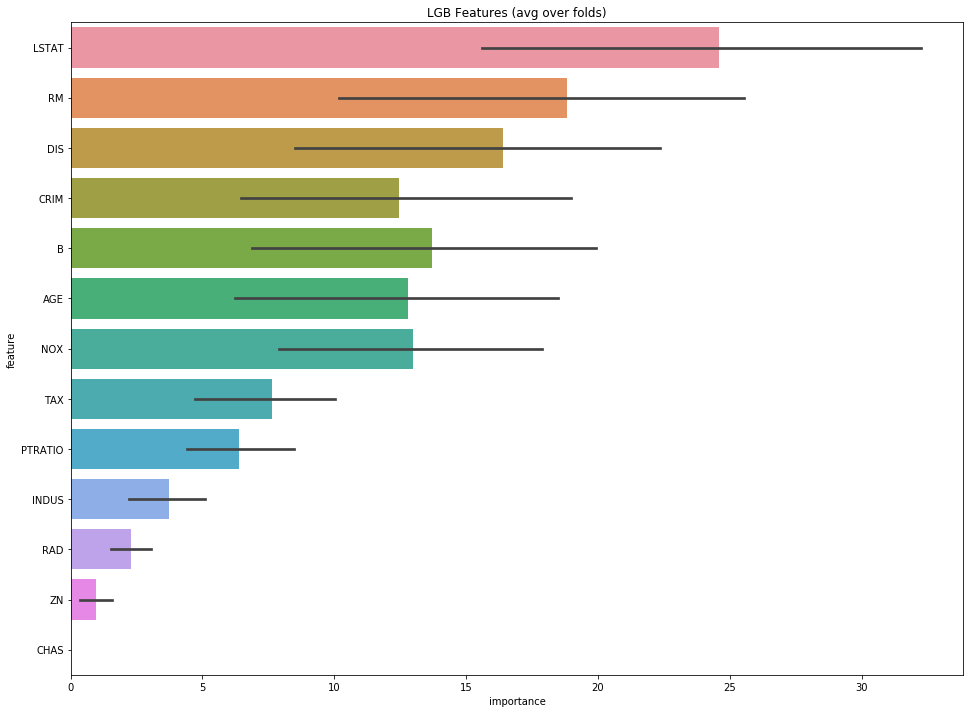

In [74]:
# top 50 features
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');


# lightGBM Regressior(using test data)

## preparation data

In [8]:
boston = load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.9,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14


In [9]:
# test data を用意しとく
# X, y は後で、クロスバリデーションのときに、train, validation セットになる
X = df
y = boston.target
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## set params

In [43]:
# Configuration
N_ESTIMATORS = 1000          # 最大学習回数
VERBOSE = 300               # 300回ごとに評価する
EARLY_STOPPING_ROUNDS = 200  # 200回の学習でよくならなければ、学習をとめる
RANDOM_STATE = 42
METRIC = mean_squared_error

# lgb_params
lgb_params = {'num_leaves': 51,
          'min_child_samples': 30,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mse',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }

## K-Fold

**5 fold**

In [44]:
n_folds = 5
folds = KFold(n_splits=n_folds, shuffle=True)

# init
result_dict = {}
oof = np.zeros(len(X))
prediction = np.zeros(len(X_test))
scores = []
models = []
feature_importance = pd.DataFrame()
for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X)):
    print('------------------')
    print(f'- fold{fold_n + 1}' )
    print(f'Fold {fold_n + 1} started at {time.ctime()}')
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]
    
    # Train the model
    model = lgb.LGBMRegressor(**lgb_params, n_estimators=N_ESTIMATORS, n_jobs=-1)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              verbose=VERBOSE,
              early_stopping_rounds=EARLY_STOPPING_ROUNDS)
    
    # predict
    y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration_)  
    y_test_pred = model.predict(X_test)
    
    oof[valid_idx] = y_valid_pred.reshape(-1,)
    scores.append(METRIC(y_valid, y_valid_pred))
    
    prediction += y_test_pred
    
    # feature_importance
    fold_importance = pd.DataFrame()
    fold_importance['feature'] = X.columns
    fold_importance['importance'] = model.feature_importances_
    fold_importance['fold'] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

# result
prediction /= folds.n_splits
feature_importance["importance"] /= folds.n_splits
result_dict['oof'] = oof
result_dict['prediction'] = prediction
result_dict['scores'] = scores
result_dict['feature_importance'] = feature_importance


print('------------------')
print('====== finish ======')
print('score list:', scores)
print('CV mean score: {0:.4f}, std: {1:.4f}'.format(np.mean(scores), np.std(scores)))

------------------
- fold1
Fold 1 started at Fri Jul 12 16:47:28 2019
Training until validation scores don't improve for 200 rounds.
[300]	training's l2: 0.623574	valid_1's l2: 12.1495
Early stopping, best iteration is:
[181]	training's l2: 1.45686	valid_1's l2: 11.6425
------------------
- fold2
Fold 2 started at Fri Jul 12 16:47:29 2019
Training until validation scores don't improve for 200 rounds.
[300]	training's l2: 0.554913	valid_1's l2: 12.6025
Early stopping, best iteration is:
[282]	training's l2: 0.625971	valid_1's l2: 12.514
------------------
- fold3
Fold 3 started at Fri Jul 12 16:47:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[45]	training's l2: 6.42943	valid_1's l2: 8.53313
------------------
- fold4
Fold 4 started at Fri Jul 12 16:47:29 2019
Training until validation scores don't improve for 200 rounds.
[300]	training's l2: 0.504119	valid_1's l2: 16.801
Early stopping, best iteration is:
[147]	training's l2: 

---> めっちゃ過学習してくるけど、まあいいや

## plot feature importance

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


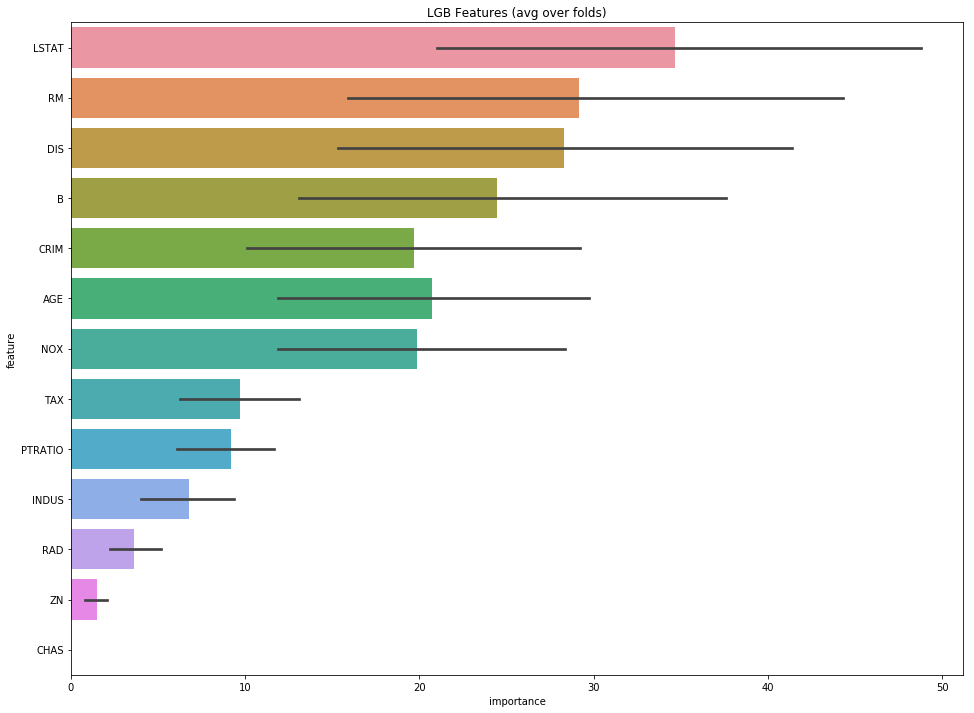

In [45]:
# top 50 features
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');
